Pylbm for solids.

Pylbm is a python-package for numerical simulations using the Lattice-Boltzmann-Method (LBM). For more general information, refer to the website https://pylbm.readthedocs.io/en/latest/, this documentation will focus on the scope of the project, which is to extend and use pylbm to solve equations of quasi-static linear elasticity in 2D. 

Here we will see how to get the common solution quantities of interest displacement, stress, strain from the computed moments for post-processing.

Disclaimer: If we transform our problem to lattice units, the results will of course also be in lattice units. To avoid writing all scaling factors over and over again, I will keep the following discussion in lattice units.

Disclaimer 2: Since we are solving quasi-static linear elastic problems, we should make sure that our simulation has converged to a solution before extracting results.

### 1. Displacement

The displacement field $[u,v]$, our primary solution quantity is solved for almost directly by the scheme in form of the moments $m_{10}$ and $m_{01}$ (remember the ordering of the moments $m = [m_{10}, m_{01}, m_{11}, m_{s}, m_{d}, m_{12}, m_{21}, m_{f}]$). 'Almost' in the sense that the displacement field is identified with the 'bared moments'

$$
u=\bar{m}_{10}=(m_{10}+m^*_{10})/2 \\
v=\bar{m}_{01}=(m_{01}+m^*_{01})/2.
$$ 

where $m_{i}$ is the pre-collision moment and $m^*_{i}$ the post-collision moment (I will use the notation $m,\bar{m},m^*$ to distinguish between the states in the following). By the order of operations, pylbm always gives populations and moments in post-collision state, therefore we have to manipulate them a bit to get the bared moments. For the displacement field this is easy: the post-collision moments are calculated from the pre-collision moments by applying the forcing $[g_x,g_y]$:

$$
m^*_{10}=m_{10}+g_x \\
m^*_{01}=m_{01}+g_y.
$$

Therefore we can compute the the displacement field from the moments by subtracting half a forcing

$$
u=m^*_{10}-g_x/2 \\
u=m^*_{01}-g_y/2.
$$ 

If solve a problem with $[g_x,g_y]=[0,0]$, we can of course use the post-collision moments provided by pylbm directly.

Let's set up a simple problem with 

$$
g_x = 1e^{-5}(sin(2 \pi xL)+cos(2 \pi yL)) \\
g_y = -1e^{-5}(cos(2 \pi xL)+sin(2 \pi yL))
$$

where L is the characteristic length. We include a convergence check using a $L_2$-grid norm of the displacement field in the simulation loop to make sure we don't run the simulation longer than needed.

In [2]:
import sympy as sp
import pylbm
import numpy as np

#geometry
dx = 0.1
dt = 0.1
la = dx/dt
L_box = 1.

#characteristic dimensions
U = 1.
L = dx
T = dt

#geometry in lattice units
dx_nd = dx/L
L_box_nd = L_box/L
la_nd = 1.

#material parameters (actual values and in lattice units)
E = 0.1/0.1731
E_nd = T/(L*L)*E
nu = .7
K = E/(2*(1-nu))
K_nd = K*T/L**2
mu = E/(2*(1+nu))
mu_nd = mu*T/L**2
theta = 1/3

#define symbols
X, Y = sp.symbols('X, Y')
u, v, LA = sp.symbols('u, v, LA')
THETA, MU_ND, K_ND, GAMMA = sp.symbols('THETA, MU_ND, K_ND, GAMMA')

#moment matrix
M = sp.Matrix([[1,0,-1,0,1,-1,-1,1],[0,1,0,-1,1,1,-1,-1],[0,0,0,0,1,-1,1,-1],[1,1,1,1,2,2,2,2],
    [1,-1,1,-1,0,0,0,0],[0,0,0,0,1,-1,-1,1],[0,0,0,0,1,1,-1,-1],[GAMMA,GAMMA,GAMMA,GAMMA,1+2*GAMMA,1+2*GAMMA,1+2*GAMMA,1+2*GAMMA]])

#equilibrium moments in order
Meq = [u,v,0,0,0,THETA*u,THETA*v,0]

#relaxation parameters
w10 = 0.
w01 = 0.
w11 = 1/(MU_ND/THETA+.5)
ws = 1/(2*K_ND/(1+THETA)+.5)
wd = 1/(2*MU_ND/(1-THETA)+.5)
w12 = 1.5
w21 = 1.5
wf = 1.
omega = [w10,w01,w11,ws,wd,w12,w21,wf]
gamma = theta*.5/((1+theta)*((1/ws-.5).evalf(subs={K_ND:K_nd,THETA:theta})-.5))

#forcing
g_x = 1e-5*(sp.sin(2*sp.pi*X*L)+sp.cos(2*sp.pi*Y*L))
g_y = -1e-5*(sp.cos(2*sp.pi*X*L)+sp.sin(2*sp.pi*Y*L))

#initial condition
def u_init(x,y):
    return 0.

def v_init(x,y):
    return 0.

dico = {
    'box' : {'x': [0,L_box_nd], 'y': [0,L_box_nd], 'label': -1},
    'space_step': dx_nd,
    'scheme_velocity': LA,
    'parameters': {LA: la_nd,
            THETA: theta,
            MU_ND: mu_nd,
            K_ND: K_nd,
            GAMMA: gamma,
            },
    'init': {u: u_init, v: v_init},
    'generator': 'cython',
    'lbm_algorithm': {'name': pylbm.algorithm.BaseAlgorithm},
    'schemes':[
            {
                'velocities': list(range(1,9)),
                'conserved_moments': [u,v],
                'M': M,
                'equilibrium': Meq,
                'relaxation_parameters': omega,
                'source_terms': {u: g_x, v: g_y}
                }]
    }

In [3]:
#create and run the simulation with a convergence check
sim = pylbm.Simulation(dico)

conv_flag = False
L2_norm = 0.
tolerance = 1e-10
max_t = 100

while(sim.nt < max_t and not conv_flag): 
    sim.one_time_step()
    #check for convergence every 10 time steps
    if not sim.nt%10:
        temp = np.sum(sim.m[0]**2+sim.m[1]**2)
        conv_flag = abs(L2_norm-temp) < tolerance
        L2_norm = temp

print('Converged:', conv_flag)
print('Computed', sim.nt, 'time steps.')
        

Converged: True
Computed 50 time steps.


Now we can compute the converged displacement solution with the moments `sim.m[0]`, `sim.m[1]` and the forcing $g_x$ and $g_y$

In [4]:
#since we defined the forcing as sympy expressions, we have to lambdify them to plug in numerical values

#function handles
g_x_f = sp.lambdify([X,Y],g_x,'numpy')
g_y_f = sp.lambdify([X,Y],g_y,'numpy')

#the moments are arrays of shape (10,10) but the coordinates are only provided in vectors; however we can use np.meshgrid to
#get coordinate arrays and calculate the forcing at every interior node at once
x,y = np.meshgrid(sim.domain.x,sim.domain.y,indexing='ij')
#the indexing='ij' option is important here to ensure the forcing array and moment array are ordered the same way

#now we compute the forcing at every interior node
g_x_arr = g_x_f(x, y)
g_y_arr = g_y_f(x, y)

#and finally compute the displacement solution
u = sim.m[0] - 0.5*g_x_arr
v = sim.m[1] - 0.5*g_y_arr


### 2. Stresses

Until now we've been focusing mostly on the moments $m_{10}$ and $m_{01}$ which are very directly related to the displacement field. Let's shift our attention to the higher order moments, which actually carry all information needed to extract the Cauchy stress components of the solution. Indeed we obtain them with

$$
\begin{align}
\sigma_{xx} &= -1/2(\bar{m}_s+\bar{m}_d) \\
\sigma_{xy} &= -\bar{m}_{11} \\
\sigma_{yy} &= -1/2(\bar{m}_s-\bar{m}_d).
\end{align}
$$

Once again we have to remember that pylbm provides post-collision moments while these definitions use bared moments. Consequently we have to use the collision rule which defines how pre-collsion moments are mapped to post-collision moments to caclulate the bared moments. The collision rule reads

$$
m^*_i = \omega_im^{eq}_i+(1-\omega_i)m_i,
$$

where $\omega_i$ are the relaxation rates and $m^{eq}_i$ the equilibrium moments (see the `'scheme'` section of the dictionary). This lets us express the bared moments in terms of post-collision moments, relaxation rates and equilibrium moments, which are all at our disposal:

$$
\bar{m}_i = \frac{1}{2}\left(\frac{m^*_i-\omega_i m^{eq}_i}{1-\omega_i}+m^*_i \right).
$$

We can simplfy this since $m^{eq}_{11}=m^{eq}_{s}=m^{eq}_d=0$ and arrive at

$$
\bar{m}_i = \frac{m^*_i}{2}\left(\frac{1}{1-\omega_i}+1 \right).
$$

Let's calculate the stress components of the above simulation:

In [5]:
#we defined the relaxation rates in terms of symbols, which we need to substitute with their numerical values:
w11_sub = w11.evalf(subs=dico['parameters'])
ws_sub = ws.evalf(subs=dico['parameters'])
wd_sub = wd.evalf(subs=dico['parameters'])

#now we can compute the bared moments (remember the ordering: m[0] = m_10, m[1] = m_01, m[2] = m_11, m[3] = m_s ...) 
m_bar_11 = 0.5*sim.m[2]*(1/(1-w11_sub)+1)
m_bar_s = 0.5*sim.m[3]*(1/(1-ws_sub)+1) 
m_bar_d = 0.5*sim.m[4]*(1/(1-wd_sub)+1)

#and finally the stress components
sigma_xx = -0.5*(m_bar_s+m_bar_d)
sigma_xy = -m_bar_11
sigma_yy = -0.5*(m_bar_s-m_bar_d)

### 3. Strains

Finally, let's compute the strain solution components. These can also be obtained from the moments $m_{11}$, $m_s$, and $m_d$:

$$
\begin{align}
\epsilon_{xx} &= -\frac{1}{4}(\tilde{K}^{-1}\bar{m}_s+\tilde{\mu}^{-1}\bar{m}_d) \\
\epsilon_{xy} &= -\frac{1}{2}\tilde{\mu}^{-1}\bar{m}_{11} \\
\epsilon_{yy} &= -\frac{1}{4}(\tilde{K}^{-1}\bar{m}_s-\tilde{\mu}^{-1}\bar{m}_d).
\end{align}
$$

$\tilde{K}$ and $\tilde{\mu}$ denote the bulk and shear modulo in lattice units which are called `K_nd` and `mu_nd` in the code examples.

In [30]:
#we already computed the bared moments for the stresses so we can directly calculate the strain components
eps_xx = -0.25*(m_bar_s/K_nd+m_bar_d/mu_nd)
eps_xy = -0.5*m_bar_11/mu_nd
eps_yy = -0.25*(m_bar_s/K_nd-m_bar_d/mu_nd)

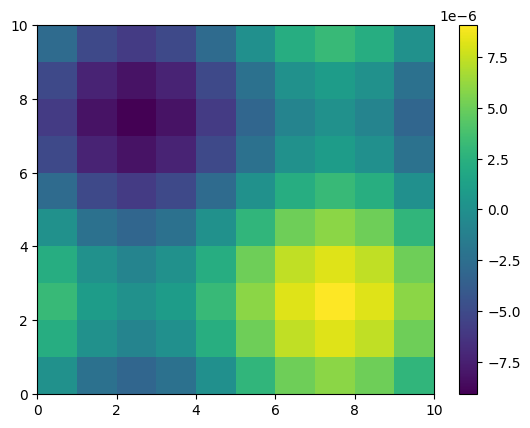

In [42]:
#Although not much insight is gained from the solution to our very arbitrarily formulated problem, let's
#plot the solution quantities

#enter the desired solution quantity here (displacements, stresses and strains):
quantity_to_plot = sigma_xy

#plot
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
im=ax.pcolormesh(quantity_to_plot.astype(float))
fig.colorbar(im,ax=ax)
plt.show()